In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import pandas.util.testing as tm # remove error warnings
%matplotlib inline

In [2]:
# set style of graphs
plt.style.use('ggplot')

In [3]:
# import the dataset
raw_data = pd.read_csv('kc_house_data.csv')

In [4]:
# examine the dataset 
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [5]:
# looking at this, there are a number of missing values and some columns that will need to be translated
# into a number type

In [6]:
# look at price - - our dependent variable
raw_data['price'].describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

In [7]:
# histogram of price to see distribution

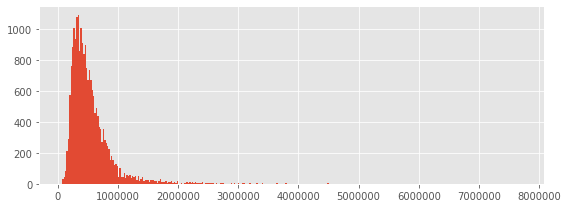

In [8]:
plt.figure(figsize=(8, 3))
raw_data['price'].hist(bins='auto')
plt.tight_layout()

In [9]:
# clear right skew

In [10]:
# 75% of values are less than $650K with the max price being significantly higher than the median of 
# $450K at $7.7M

In [11]:
raw_data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [12]:
# remove id column as it won't help with regression
clean_data = raw_data.drop('id', axis=1)

In [13]:
clean_data.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [14]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(10), object(2)
memory usage: 3.3+ MB


In [15]:
# handle missing values: waterfront, yr_renovated, view are columns with missing values

In [16]:
# Waterfront Missing Values
clean_data['waterfront'].nunique()

2

In [17]:
clean_data['waterfront'].unique()

array([nan,  0.,  1.])

In [18]:
# how many values are nan
clean_data['waterfront'].isna().sum()

2376

In [19]:
# given how many values this is, going to keep the data in for now
# set all nans to 0 as houses missing waterfront information likely do not have waterfronts
clean_data['waterfront'] = clean_data['waterfront'].fillna(value=0.)

In [20]:
# yr_renovated missing values
clean_data['yr_renovated'].nunique()

70

In [21]:
clean_data['yr_renovated'].unique()

array([   0., 1991.,   nan, 2002., 2010., 1992., 2013., 1994., 1978.,
       2005., 2003., 1984., 1954., 2014., 2011., 1983., 1945., 1990.,
       1988., 1977., 1981., 1995., 2000., 1999., 1998., 1970., 1989.,
       2004., 1986., 2007., 1987., 2006., 1985., 2001., 1980., 1971.,
       1979., 1997., 1950., 1969., 1948., 2009., 2015., 1974., 2008.,
       1968., 2012., 1963., 1951., 1962., 1953., 1993., 1996., 1955.,
       1982., 1956., 1940., 1976., 1946., 1975., 1964., 1973., 1957.,
       1959., 1960., 1967., 1965., 1934., 1972., 1944., 1958.])

In [22]:
# how many are missing values?
clean_data['yr_renovated'].isna().sum()

3842

In [23]:
# similar to waterfront, going to assume that missing yr_renovated data is likely the result of a house 
# not having a renovation - - reassign all nans to 0.
clean_data['yr_renovated'] = clean_data['yr_renovated'].fillna(value=0.)

In [24]:
# View missing values
clean_data['view'].isna().sum()

63

In [25]:
clean_data['view'].unique()

array([ 0., nan,  3.,  4.,  2.,  1.])

In [26]:
# view relates to the number of times a house has been viewed -- similar to above assuming that
# missing values are related to houses that have not been viewed -- reassign all nans to 0.
clean_data['view'] = clean_data['view'].fillna(value=0.)

In [27]:
# check for any remaining missing values
clean_data.isna().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [28]:
# no more missing values

In [29]:
# check for any duplicates
clean_data.duplicated().any()

False

In [30]:
# there are no duplicates

In [31]:
# Handle strings and convert all columns to appropriate types for regression
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     21597 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(10), object(2)
memory usage: 3.3+ MB


In [32]:
clean_data['sqft_basement'].unique()

array(['0.0', '400.0', '910.0', '1530.0', '?', '730.0', '1700.0', '300.0',
       '970.0', '760.0', '720.0', '700.0', '820.0', '780.0', '790.0',
       '330.0', '1620.0', '360.0', '588.0', '1510.0', '410.0', '990.0',
       '600.0', '560.0', '550.0', '1000.0', '1600.0', '500.0', '1040.0',
       '880.0', '1010.0', '240.0', '265.0', '290.0', '800.0', '540.0',
       '710.0', '840.0', '380.0', '770.0', '480.0', '570.0', '1490.0',
       '620.0', '1250.0', '1270.0', '120.0', '650.0', '180.0', '1130.0',
       '450.0', '1640.0', '1460.0', '1020.0', '1030.0', '750.0', '640.0',
       '1070.0', '490.0', '1310.0', '630.0', '2000.0', '390.0', '430.0',
       '850.0', '210.0', '1430.0', '1950.0', '440.0', '220.0', '1160.0',
       '860.0', '580.0', '2060.0', '1820.0', '1180.0', '200.0', '1150.0',
       '1200.0', '680.0', '530.0', '1450.0', '1170.0', '1080.0', '960.0',
       '280.0', '870.0', '1100.0', '460.0', '1400.0', '660.0', '1220.0',
       '900.0', '420.0', '1580.0', '1380.0', '475.0', 

In [33]:
# replace '?' with zero as assumption is this relates to houses without a basement
clean_data['sqft_basement'] = clean_data['sqft_basement'].replace(to_replace = '?',
                                                                  value = '0.0')

In [34]:
# convert basement column to a number format
clean_data['sqft_basement'] = clean_data['sqft_basement'].astype('float64')

In [35]:
# handle date column - - convert to a datetime type and then split year, month, and day into separate columns

In [36]:
# check format of the date column
clean_data['date'].unique()

array(['10/13/2014', '12/9/2014', '2/25/2015', '2/18/2015', '5/12/2014',
       '6/27/2014', '1/15/2015', '4/15/2015', '3/12/2015', '4/3/2015',
       '5/27/2014', '5/28/2014', '10/7/2014', '1/24/2015', '7/31/2014',
       '5/29/2014', '12/5/2014', '4/24/2015', '5/14/2014', '8/26/2014',
       '7/3/2014', '5/16/2014', '11/20/2014', '11/3/2014', '6/26/2014',
       '12/1/2014', '6/24/2014', '3/2/2015', '11/10/2014', '12/3/2014',
       '6/13/2014', '12/30/2014', '2/13/2015', '6/20/2014', '7/15/2014',
       '8/11/2014', '7/7/2014', '10/28/2014', '7/29/2014', '7/18/2014',
       '3/25/2015', '7/16/2014', '4/28/2015', '3/11/2015', '9/16/2014',
       '2/17/2015', '12/31/2014', '2/5/2015', '3/3/2015', '8/19/2014',
       '4/7/2015', '8/27/2014', '2/23/2015', '12/10/2014', '8/28/2014',
       '10/21/2014', '12/7/2014', '6/3/2014', '9/9/2014', '10/9/2014',
       '8/25/2014', '6/12/2014', '9/12/2014', '1/5/2015', '6/10/2014',
       '7/10/2014', '3/16/2015', '11/5/2014', '4/20/2015', '6/9/20

In [37]:
# format is clearly MM-DD-YYYY

In [38]:
pd.to_datetime(clean_data['date'], infer_datetime_format=True)

0       2014-10-13
1       2014-12-09
2       2015-02-25
3       2014-12-09
4       2015-02-18
           ...    
21592   2014-05-21
21593   2015-02-23
21594   2014-06-23
21595   2015-01-16
21596   2014-10-15
Name: date, Length: 21597, dtype: datetime64[ns]

In [39]:
clean_data['date'] = pd.to_datetime(clean_data['date'], infer_datetime_format=True)

In [40]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null float64
yr_built         21597 non-null int64
yr_renovated     21597 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: datetime64[ns](1), float64(9), int64(10)
memory usage: 3.3 MB


In [41]:
# create individual columns
clean_data['year_sold'] = clean_data['date'].map(lambda x: x.year)
clean_data['month_sold'] = clean_data['date'].map(lambda x: x.month)
clean_data['day_sold'] = clean_data['date'].map(lambda x: x.day)

In [42]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 23 columns):
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null float64
yr_built         21597 non-null int64
yr_renovated     21597 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
year_sold        21597 non-null int64
month_sold       21597 non-null int64
day_sold         21597 non-n

In [43]:
# drop date column
clean_data = clean_data.drop('date', axis=1)

In [44]:
# before further preprocessing / evaluating distributions, etc. run a baseline regression
# note that this will not necessary meet all assumptions for regression, just a baseline

In [45]:
y = clean_data['price']
X = clean_data.drop('price', axis=1)

In [46]:
# import statsmodels
import statsmodels.api as sm

In [47]:
# add constant
predictors = sm.add_constant(X)

/Users/kaigraham/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [48]:
# fit model
model = sm.OLS(y, predictors).fit()

In [49]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     2417.
Date:                Wed, 17 Feb 2021   Prob (F-statistic):               0.00
Time:                        21:08:28   Log-Likelihood:            -2.9433e+05
No. Observations:               21597   AIC:                         5.887e+05
Df Residuals:                   21575   BIC:                         5.889e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -6.701e+07   9.97e+06     -6.720      0.000   -8.66e+07   -4.75e+07
bedrooms      -3.611e+04   1895.753    -19.049      0.000   -3.98e+04   -3.24e+04
bathrooms      4.185e+04   3254.292     12.860      0.000    3.55e+04    4.82e+04
sqft_living     103.9198     18.029      5.764      0.000      68.581     139.259
sqft_lot          0.1247      0.048      2.610      0.009       0.031       0.218
floors         7567.8739   3591.816      2.107      0.035     527.649    1.46e+04
waterfront     6.192e+05   1.81e+04     34.229      0.000    5.84e+05    6.55e+05
view             5.3e+04   2116.828     25.036      0.000    4.88e+04    5.71e+04
condition      2.819e+04   2344.383     12.024      0.000    2.36e+04    3.28e+04
grade          9.714e+04   2155.383     45.068      0.000    9.29e+04    1.01e+05
sqft_above       77.0570     18.021      4.276      0.000      41.735     112.379
sqft_basement    46.7398     17.861      2.617      0.009      11.732      81.748
yr_built      -2638.3199     71.741    -36.776      0.000   -2778.938   -2497.702
yr_renovated     24.5890      3.968      6.197      0.000      16.811      32.367
zipcode        -585.0212     32.906    -17.778      0.000    -649.520    -520.522
lat            6.031e+05   1.07e+04     56.293      0.000    5.82e+05    6.24e+05
long          -2.176e+05   1.31e+04    -16.581      0.000   -2.43e+05   -1.92e+05
sqft_living15    21.6016      3.442      6.277      0.000      14.856      28.348
sqft_lot15       -0.3862      0.073     -5.279      0.000      -0.530      -0.243
year_sold      3.654e+04   4722.374      7.738      0.000    2.73e+04    4.58e+04
month_sold     1139.0264    708.874      1.607      0.108    -250.418    2528.471
day_sold       -361.6816    159.188     -2.272      0.023    -673.701     -49.662
==============================================================================
Omnibus:                    18382.670   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1863250.788
Skew:                           3.571   Prob(JB):                         0.00
Kurtosis:                      47.939   Cond. No.                     7.35e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.35e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [50]:
# run in sklearn and run cross-val
regression = LinearRegression().fit(predictors, y)
crossvalidation = KFold(n_splits=3, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(regression, predictors, y, scoring='r2', cv=crossvalidation))
baseline

0.6978643497917227

In [51]:
# evaluate columns, relationships between predictors and price, to refine model remove columns
# that violate assumptions, etc. 
# begin further preprocessing, OHE, etc. to try and improve results, ensure assumptions are met

In [52]:
"""
Function to plot y vs. a chosen set of x variables
"""
def plot_x_y(x_vals, y_val, data):
    fig, axes = plt.subplots(nrows = 1, ncols=len(x_vals), figsize=(20,5))
    for xcol, ax in zip(x_vals, axes):
        data.plot(kind='scatter', x=xcol, y=y_val, ax=ax, alpha=0.5)
    plt.style.use('ggplot')
    plt.tight_layout()
    plt.show()

In [53]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 22 columns):
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null float64
yr_built         21597 non-null int64
yr_renovated     21597 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
year_sold        21597 non-null int64
month_sold       21597 non-null int64
day_sold         21597 non-null int64
dtypes: float64(9), int64(13)
memory 

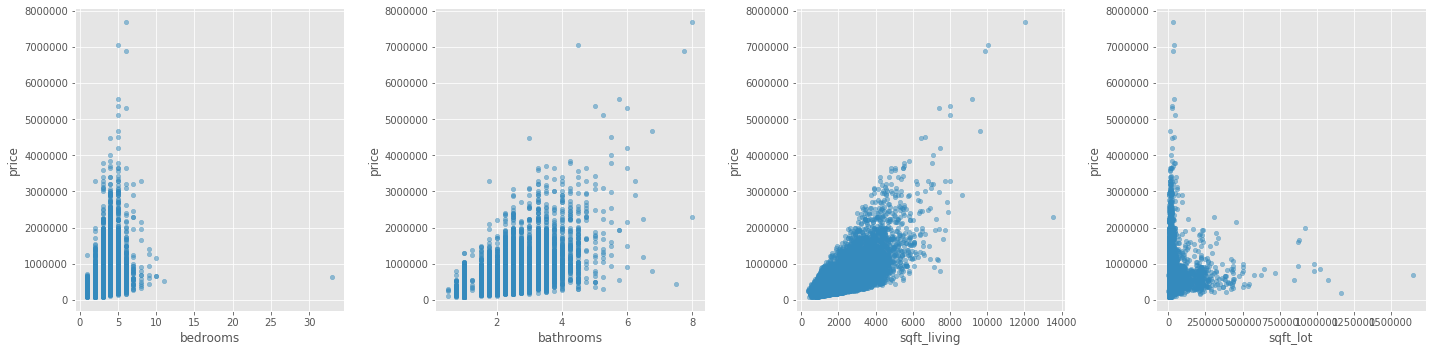

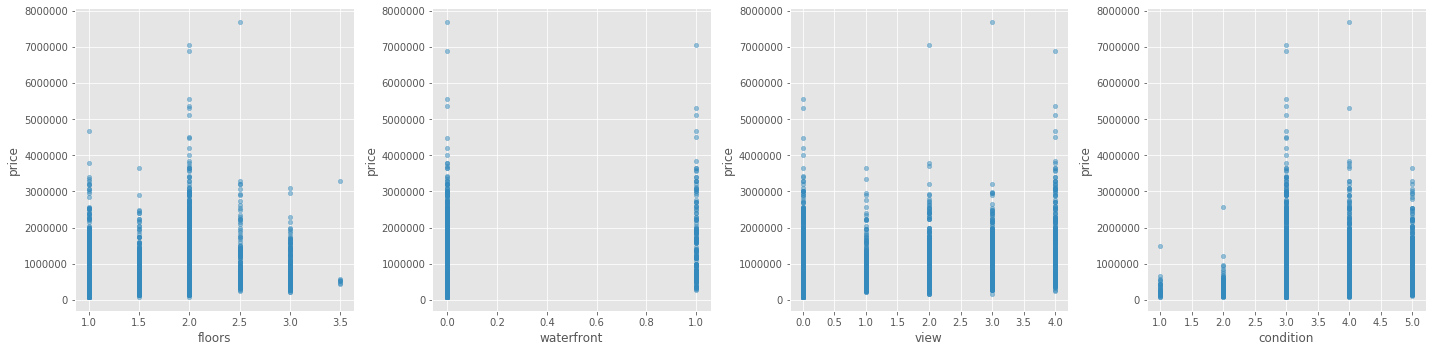

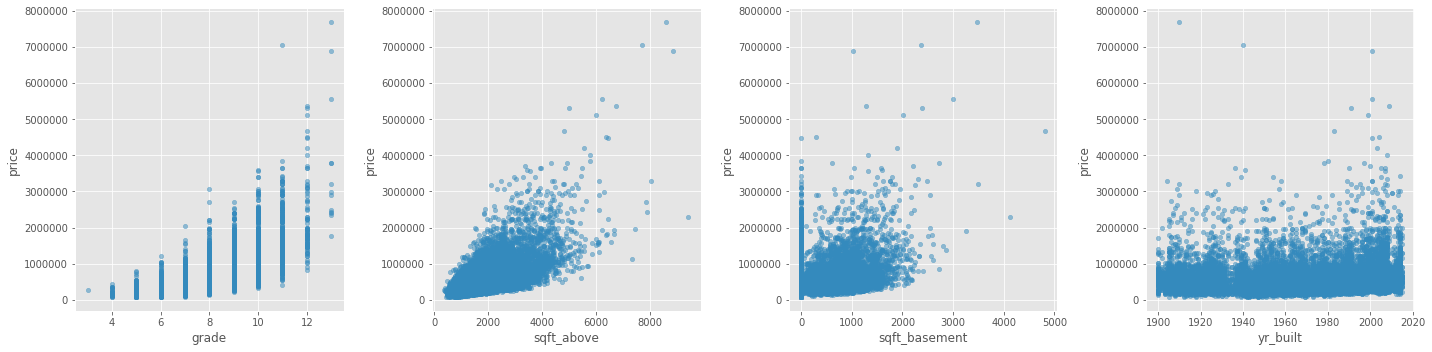

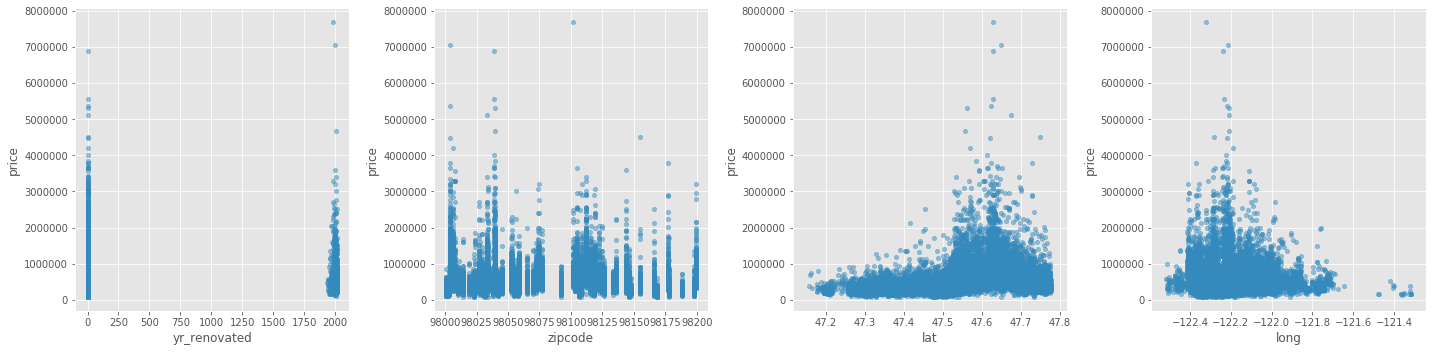

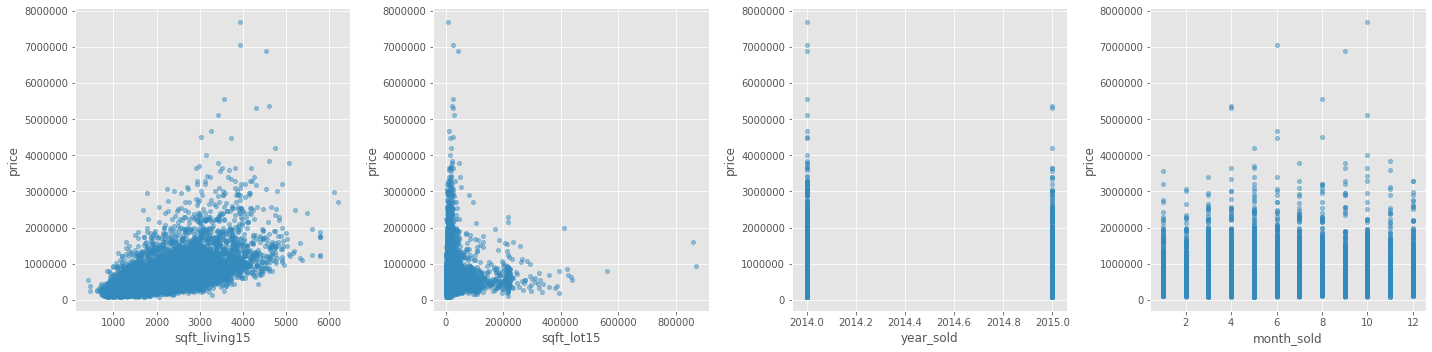

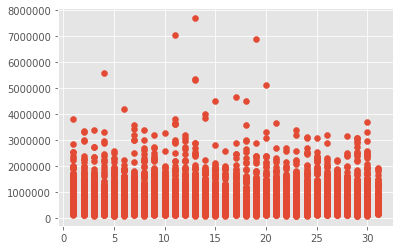

In [54]:
# plot all columns against price
plot_x_y(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot'], 'price', data=clean_data)
plot_x_y(['floors', 'waterfront', 'view', 'condition'], 'price', data=clean_data)
plot_x_y(['grade', 'sqft_above', 'sqft_basement', 'yr_built'], 'price', data=clean_data)
plot_x_y(['yr_renovated', 'zipcode', 'lat', 'long'], 'price', data=clean_data)
plot_x_y(['sqft_living15', 'sqft_lot15', 'year_sold', 'month_sold'], 'price', data=clean_data)
plt.scatter(x=clean_data['day_sold'], y=clean_data['price'])

In [55]:
# separate clear continous and categorical data
cont_cols = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 
                  'lat', 'long', 'sqft_living15', 'sqft_lot15']
cat_cols = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade',
                 'yr_renovated', 'yr_built', 'zipcode', 'year_sold', 'month_sold', 'day_sold']

In [56]:
# create dataframes
cont_variables = clean_data[cont_cols]
cat_variables = clean_data[cat_cols]

In [57]:
# start preprocessing with the categorical data
# will need to separate out true categorical data and ordinal data - - ordinal data will be left as a single col,
# non-ordinal data will be one hot encoded

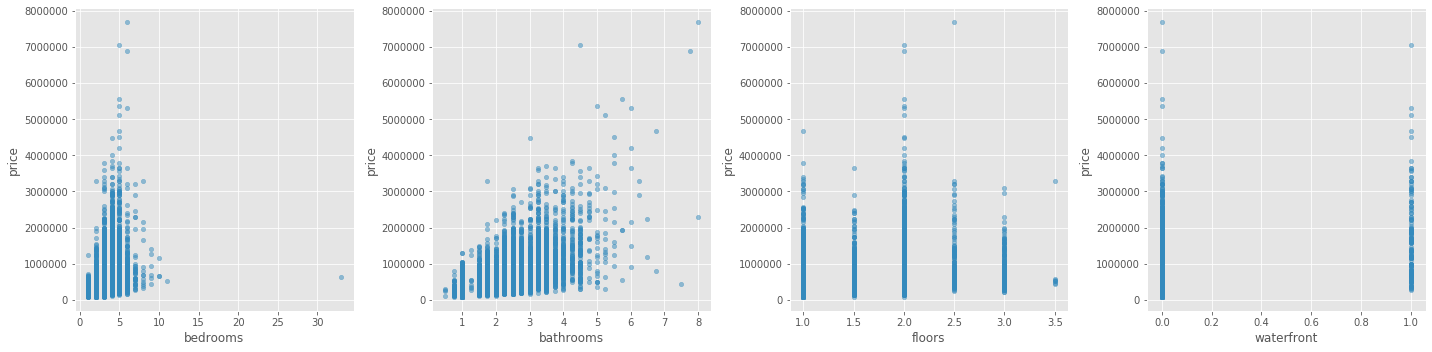

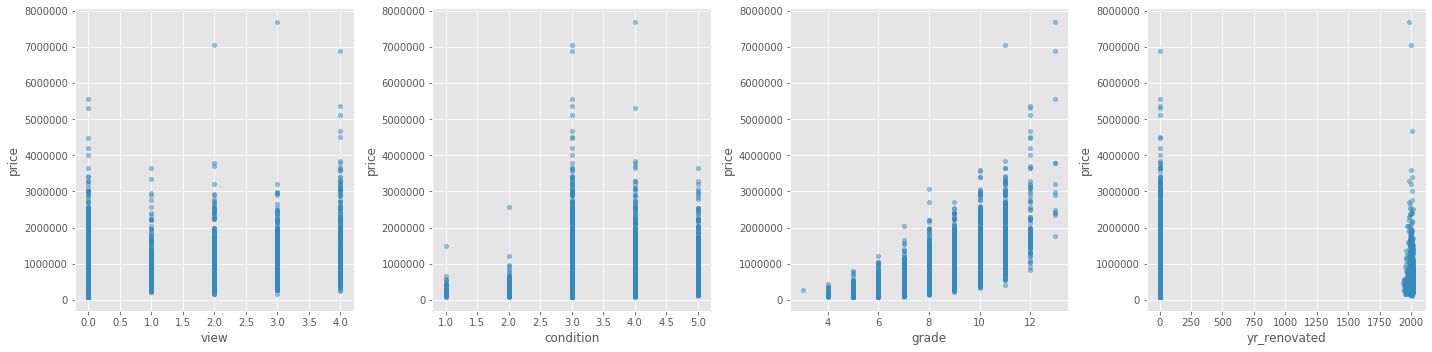

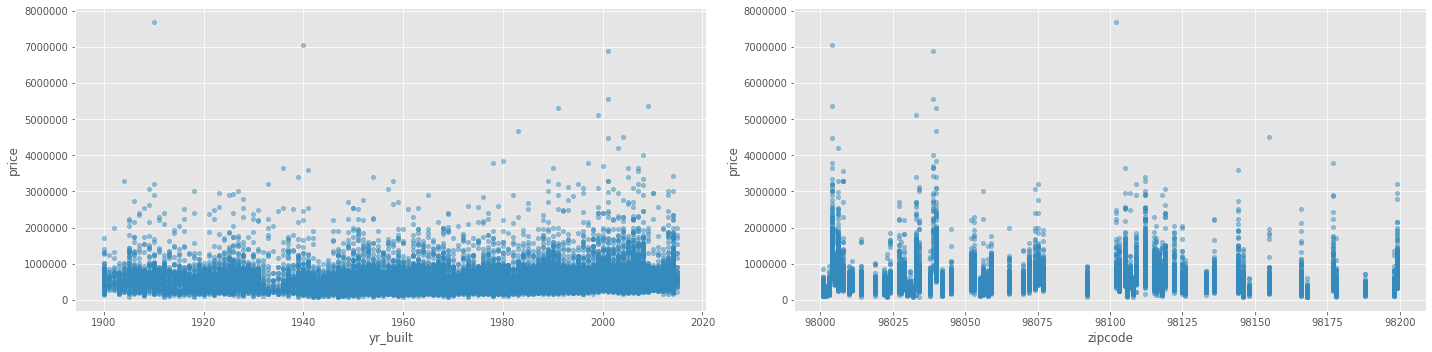

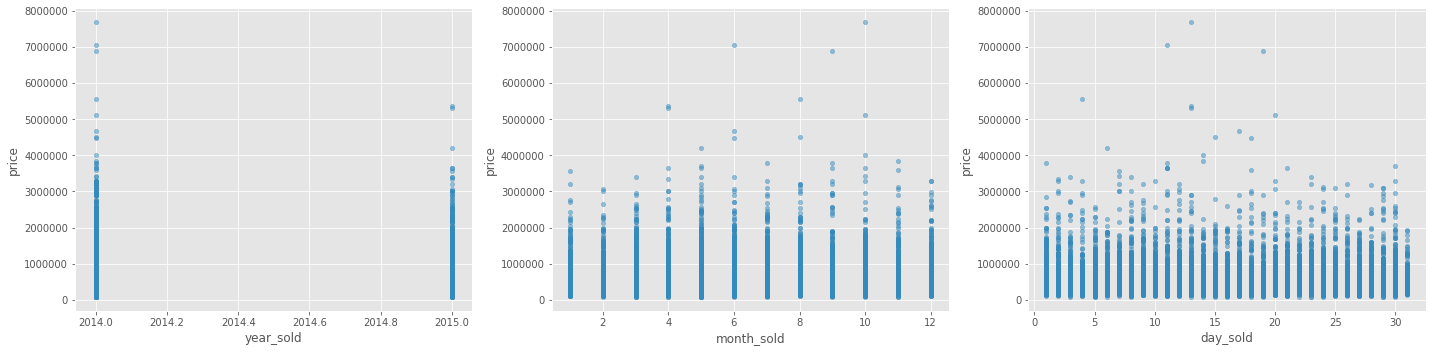

In [58]:
# replot against price to see relationships, distributions, etc.
plot_x_y(['bedrooms', 'bathrooms', 'floors', 'waterfront'], 'price', data=clean_data)
plot_x_y(['view', 'condition', 'grade', 'yr_renovated'], 'price', data=clean_data)
plot_x_y(['yr_built', 'zipcode'], 'price', data=clean_data)
plot_x_y(['year_sold', 'month_sold', 'day_sold'], 'price', data=clean_data)

In [59]:
clean_data['year_sold'].unique()

array([2014, 2015])

In [60]:
# the data only includes houses sold in 2014 and 2015

In [61]:
cat_variables.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 13 columns):
bedrooms        21597 non-null int64
bathrooms       21597 non-null float64
floors          21597 non-null float64
waterfront      21597 non-null float64
view            21597 non-null float64
condition       21597 non-null int64
grade           21597 non-null int64
yr_renovated    21597 non-null float64
yr_built        21597 non-null int64
zipcode         21597 non-null int64
year_sold       21597 non-null int64
month_sold      21597 non-null int64
day_sold        21597 non-null int64
dtypes: float64(5), int64(8)
memory usage: 2.1 MB


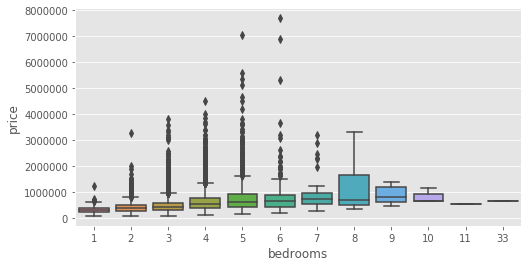

In [62]:
# plot boxplots to see if there is an ordinal relationship
plt.figure(figsize=(8,4))
ax = sns.boxplot(x='bedrooms', y='price', data=clean_data)
plt.show()

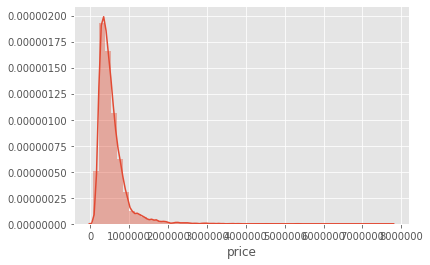

In [63]:
# there are a lot of outliers on price
# look at distribution of price again
sns.distplot(clean_data['price'])

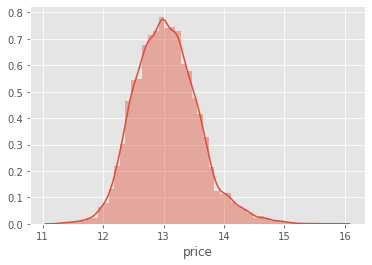

In [64]:
# look at the log of price
sns.distplot(np.log(clean_data['price']))

In [65]:
# log transform price
clean_data['log_price'] = np.log(clean_data['price'])

In [66]:
""""""
# drop original price column
preprocessed = clean_data.drop('price', axis=1)

In [67]:
# rerun model to see if this helps improve results
y = preprocessed['log_price']
X = preprocessed.drop('log_price', axis=1)

predictors = sm.add_constant(X)
model = sm.OLS(y, predictors).fit()

/Users/kaigraham/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [68]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     3488.
Date:                Wed, 17 Feb 2021   Prob (F-statistic):               0.00
Time:                        21:08:37   Log-Likelihood:                -804.17
No. Observations:               21597   AIC:                             1652.
Df Residuals:                   21575   BIC:                             1828.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -129.8221     12.483    -10.400      0.000    -154.289    -105.355
bedrooms         -0.0128      0.002     -5.402      0.000      -0.017      -0.008
bathrooms         0.0702      0.004     17.237      0.000       0.062       0.078
sqft_living       0.0001   2.26e-05      5.868      0.000    8.82e-05       0.000
sqft_lot       4.628e-07   5.98e-08      7.734      0.000    3.46e-07     5.8e-07
floors            0.0766      0.004     17.027      0.000       0.068       0.085
waterfront        0.3782      0.023     16.700      0.000       0.334       0.423
view              0.0617      0.003     23.266      0.000       0.056       0.067
condition         0.0649      0.003     22.105      0.000       0.059       0.071
grade             0.1603      0.003     59.397      0.000       0.155       0.166
sqft_above     3.652e-06   2.26e-05      0.162      0.871   -4.06e-05    4.79e-05
sqft_basement  1.918e-05   2.24e-05      0.858      0.391   -2.46e-05     6.3e-05
yr_built         -0.0034   8.98e-05    -38.406      0.000      -0.004      -0.003
yr_renovated   4.133e-05   4.97e-06      8.319      0.000    3.16e-05    5.11e-05
zipcode          -0.0007   4.12e-05    -15.820      0.000      -0.001      -0.001
lat               1.4017      0.013    104.526      0.000       1.375       1.428
long             -0.1598      0.016     -9.727      0.000      -0.192      -0.128
sqft_living15  9.785e-05   4.31e-06     22.713      0.000    8.94e-05       0.000
sqft_lot15    -2.634e-07   9.16e-08     -2.876      0.004   -4.43e-07   -8.39e-08
year_sold         0.0622      0.006     10.515      0.000       0.051       0.074
month_sold        0.0021      0.001      2.327      0.020       0.000       0.004
day_sold         -0.0005      0.000     -2.503      0.012      -0.001      -0.000
==============================================================================
Omnibus:                      387.151   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              792.440
Skew:                          -0.042   Prob(JB):                    8.39e-173
Kurtosis:                       3.935   Cond. No.                     7.35e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.35e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [69]:
# cross-fold validation
regression = LinearRegression().fit(predictors, y)
crossvalidation = KFold(n_splits=3, shuffle=True, random_state=1)
model_2 = np.mean(cross_val_score(regression, predictors, y, scoring='r2', cv=crossvalidation))
model_2

0.7715848510006489

In [70]:
model_2 - baseline

0.07372050120892615

In [71]:
# by log transforming price, we see a significant improvement on r2 value - - still may not meet all assumptions

In [72]:
# continue with preprocessing cat data
cont_variables = preprocessed[cont_cols]
cat_variables = preprocessed[cat_cols]

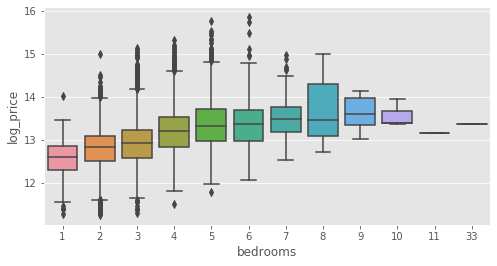

In [73]:
# Bedrooms
plt.figure(figsize=(8,4))
ax = sns.boxplot(x='bedrooms', y='log_price', data=preprocessed)
plt.show()

In [74]:
# there seems to be an ordinal relationship here, that is slightly linear - - keep as a single column

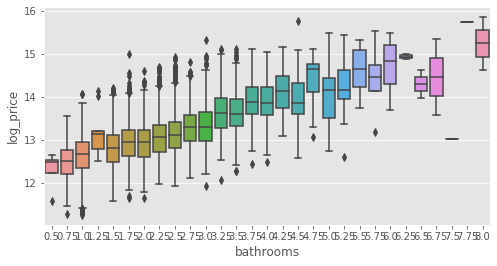

In [75]:
# Bathrooms
plt.figure(figsize=(8,4))
ax = sns.boxplot(x='bathrooms', y='log_price', data=preprocessed)
plt.show()

In [76]:
# there is an ordinal relationship here as well that appears more or less linear - - keep as a single column

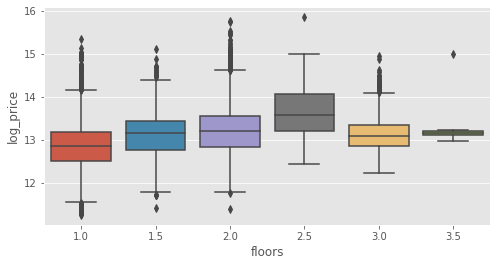

In [77]:
# Floors
plt.figure(figsize=(8,4))
ax = sns.boxplot(x='floors', y='log_price', data=preprocessed)
plt.show()

In [78]:
# Not as ordinal of a relationship - - OHE
floor_dummies = pd.get_dummies(preprocessed['floors'], prefix='floors', drop_first=True)

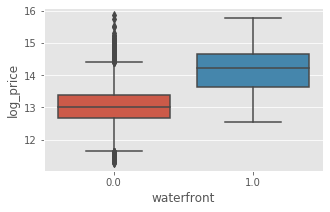

In [79]:
# Waterfront
plt.figure(figsize=(5,3))
ax = sns.boxplot(x='waterfront', y='log_price', data=preprocessed)
plt.show()

In [80]:
# only two possible values so will OHE
waterfront_dummies = pd.get_dummies(preprocessed['waterfront'], prefix='waterfront', drop_first=True)

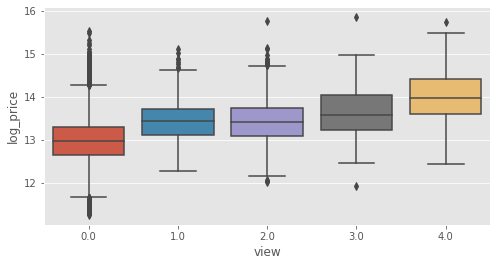

In [81]:
# View
plt.figure(figsize=(8,4))
ax = sns.boxplot(x='view', y='log_price', data=preprocessed)
plt.show()

In [82]:
# seems like there is an ordinal relationship here - - will leave as a single column for now

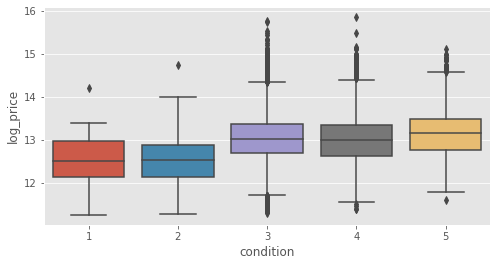

In [83]:
# Condition
plt.figure(figsize=(8,4))
ax = sns.boxplot(x='condition', y='log_price', data=preprocessed)
plt.show()

In [84]:
# no clear ordinal relationship - - OHE
condition_dummies = pd.get_dummies(preprocessed['condition'], prefix='condition', drop_first=True)

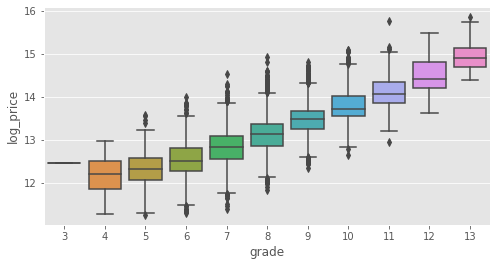

In [85]:
# Grade
plt.figure(figsize=(8,4))
ax = sns.boxplot(x='grade', y='log_price', data=preprocessed)
plt.show()

In [86]:
# clear ordinal relationship, leave as a single column

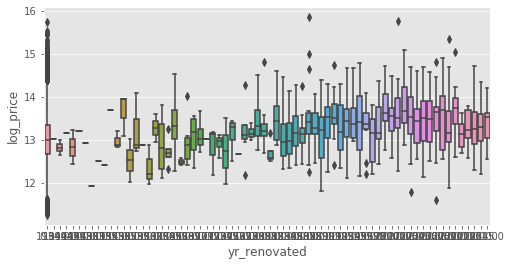

In [87]:
# Year Renovated
plt.figure(figsize=(8,4))
ax = sns.boxplot(x='yr_renovated', y='log_price', data=preprocessed)
plt.show()

In [88]:
# would not say there is a clear relationship here - try OHE
yr_reno_dummies = pd.get_dummies(preprocessed['yr_renovated'], prefix='yr_reno', drop_first=True)

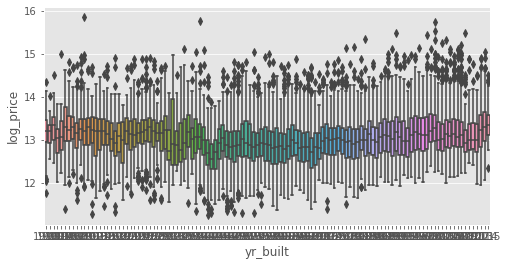

In [89]:
# Year Built
plt.figure(figsize=(8,4))
ax = sns.boxplot(x='yr_built', y='log_price', data=preprocessed)
plt.show()

In [90]:
# no clear relationship - - OHE
yr_built_dummies = pd.get_dummies(preprocessed['yr_built'], prefix='yr_built', drop_first=True)

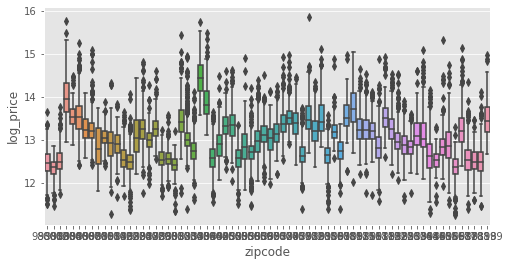

In [91]:
# Zipcode
plt.figure(figsize=(8,4))
ax = sns.boxplot(x='zipcode', y='log_price', data=preprocessed)
plt.show()

In [92]:
# no clear relationship, OHE
zipcode_dummies = pd.get_dummies(preprocessed['zipcode'], prefix='zipcode', drop_first=True)

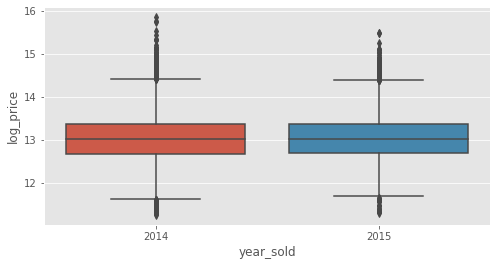

In [93]:
# Year Sold
plt.figure(figsize=(8,4))
ax = sns.boxplot(x='year_sold', y='log_price', data=preprocessed)
plt.show()

In [94]:
# OHE
year_sold_dummies = pd.get_dummies(preprocessed['year_sold'], prefix='yr_sold', drop_first=True)

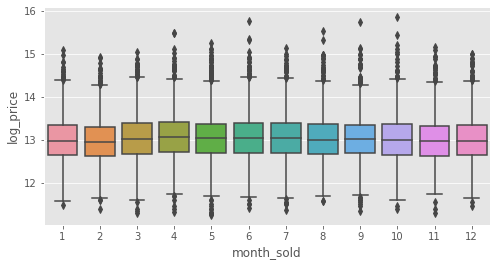

In [95]:
# Month Sold
plt.figure(figsize=(8,4))
ax = sns.boxplot(x='month_sold', y='log_price', data=preprocessed)
plt.show()

In [96]:
# again no clear relationship, OHE
month_sold_dummies = pd.get_dummies(preprocessed['month_sold'], prefix='month_sold', drop_first=True)

In [97]:
# Day Sold
day_sold_dummies = pd.get_dummies(preprocessed['day_sold'], prefix='day_sold', drop_first=True)

In [98]:
# now that we have created some dummy variables - concat and rerun to see if any improvement
dummy_list = [floor_dummies, waterfront_dummies, condition_dummies, 
              yr_reno_dummies, yr_built_dummies, zipcode_dummies, 
              year_sold_dummies, month_sold_dummies, day_sold_dummies]

In [99]:
preprocessed = pd.concat([preprocessed, floor_dummies, waterfront_dummies, condition_dummies,
                          yr_reno_dummies, yr_built_dummies, zipcode_dummies, year_sold_dummies,
                          month_sold_dummies, day_sold_dummies], axis=1)

In [100]:
# drop columns
preprocessed = preprocessed.drop(['floors', 'waterfront', 'condition', 'yr_renovated', 
                                  'yr_built', 'zipcode', 'year_sold', 'month_sold', 'day_sold'], axis=1)

In [101]:
# rerun the model to see if results improve at all

In [102]:
y = preprocessed['log_price']
X = preprocessed.drop('log_price', axis=1)

In [103]:
predictors = sm.add_constant(X)
model = sm.OLS(y, predictors).fit()

/Users/kaigraham/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [104]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     519.0
Date:                Wed, 17 Feb 2021   Prob (F-statistic):               0.00
Time:                        21:08:44   Log-Likelihood:                 6608.1
No. Observations:               21597   AIC:                        -1.258e+04
Df Residuals:                   21279   BIC:                        -1.004e+04
Df Model:                         317                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -64.8220      6.923     -9.363      0.000     -78.392     -51.252
bedrooms           0.0044      0.002      2.484      0.013       0.001       0.008
bathrooms          0.0358      0.003     11.814      0.000       0.030       0.042
sqft_living        0.0001   1.63e-05      6.793      0.000    7.87e-05       0.000
sqft_lot        6.461e-07   4.32e-08     14.944      0.000    5.61e-07    7.31e-07
view               0.0627      0.002     31.848      0.000       0.059       0.067
grade              0.0936      0.002     44.792      0.000       0.090       0.098
sqft_above      8.131e-05   1.63e-05      4.977      0.000    4.93e-05       0.000
sqft_basement   1.888e-05   1.61e-05      1.171      0.241   -1.27e-05    5.05e-05
lat                0.5398      0.071      7.554      0.000       0.400       0.680
long              -0.4102      0.051     -7.988      0.000      -0.511      -0.310
sqft_living15   7.974e-05   3.29e-06     24.262      0.000    7.33e-05    8.62e-05
sqft_lot15      1.187e-07   6.82e-08      1.740      0.082    -1.5e-08    2.52e-07
floors_1.5         0.0038      0.005      0.729      0.466      -0.006       0.014
floors_2.0        -0.0345      0.005     -7.661      0.000      -0.043      -0.026
floors_2.5        -0.0426      0.015     -2.797      0.005      -0.072      -0.013
floors_3.0        -0.1353      0.010    -14.232      0.000      -0.154      -0.117
floors_3.5        -0.1399      0.068     -2.044      0.041      -0.274      -0.006
waterfront_1.0     0.4603      0.017     27.663      0.000       0.428       0.493
condition_2        0.1447      0.037      3.962      0.000       0.073       0.216
condition_3        0.2770      0.034      8.165      0.000       0.210       0.343
condition_4        0.3342      0.034      9.847      0.000       0.268       0.401
condition_5        0.4012      0.034     11.748      0.000       0.334       0.468
yr_reno_1934.0     0.1110      0.181      0.613      0.540      -0.244       0.466
yr_reno_1940.0    -0.1806      0.128     -1.410      0.159      -0.432       0.070
yr_reno_1944.0     0.1265      0.181      0.698      0.485      -0.229       0.482
yr_reno_1945.0     0.0037      0.105      0.036      0.972      -0.202       0.209
yr_reno_1946.0     0.1651      0.181      0.914      0.361      -0.189       0.519
yr_reno_1948.0    -0.0132      0.181     -0.073      0.942      -0.369       0.342
yr_reno_1950.0    -0.3257      0.182     -1.793      0.073      -0.682       0.030
yr_reno_1951.0    -0.0195      0.181     -0.108      0.914      -0.375       0.336
yr_reno_1953.0    -0.2383      0.182     -1.307      0.191      -0.596       0.119
yr_reno_1954.0     0.6125      0.181      3.389      0.001       0.258       0.967
yr_reno_1955.0     0.0550      0.105      0.527      0.598      -0.150       0.260
yr_reno_1956

In [105]:
# r2 value is up now, again assumptions have not been checked yet

In [106]:
# cross validation
regression = LinearRegression().fit(predictors, y)
crossvalidation = KFold(n_splits=3, shuffle=True, random_state=1)
model_3 = np.mean(cross_val_score(regression, predictors, y, scoring='r2', cv=crossvalidation))
model_3

0.8804363925842592

In [107]:
model_3 - model_2

0.10885154158361032

In [108]:
# move to preprocessing cont data
cont_variables = preprocessed[cont_cols]

In [109]:
# replot against price to evaluate relationships

In [110]:
cont_variables.columns

Index(['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

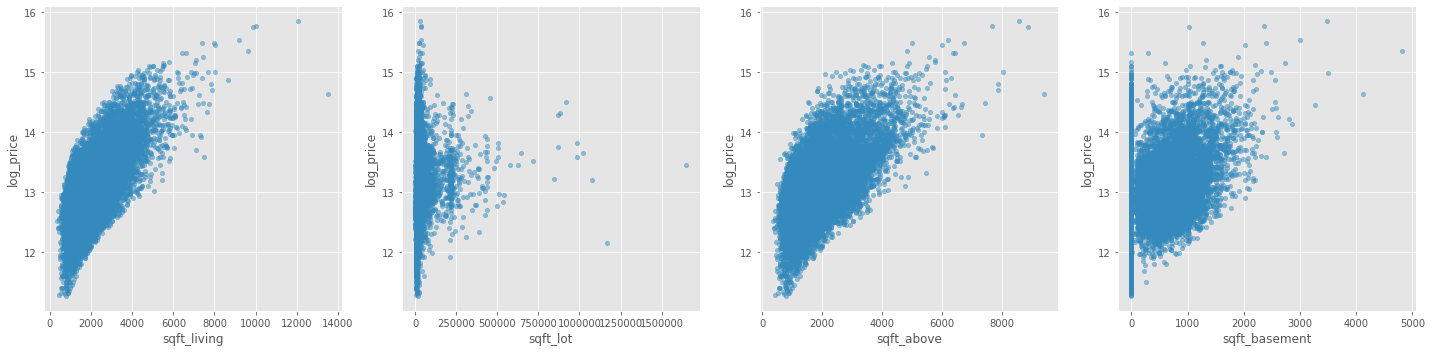

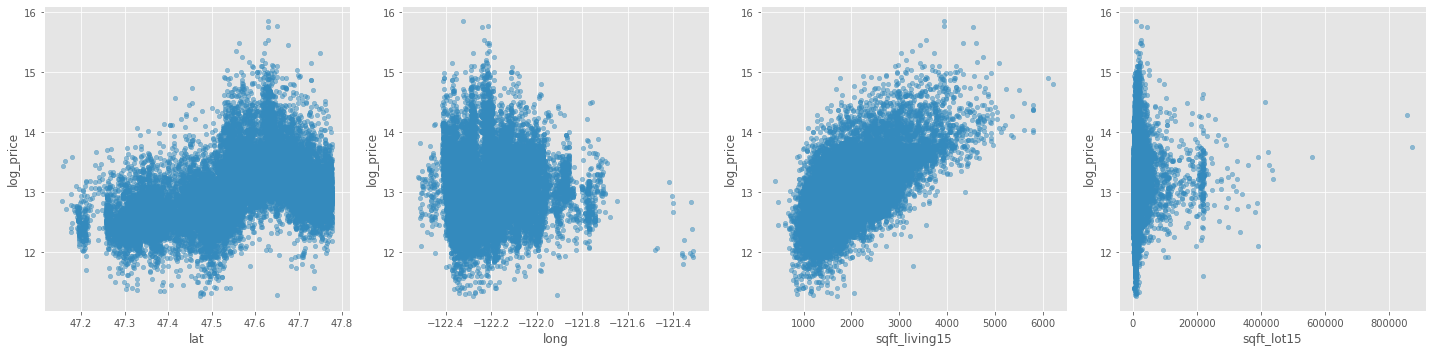

In [111]:
plot_x_y(['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement'], 'log_price', data=preprocessed)
plot_x_y(['lat', 'long', 'sqft_living15', 'sqft_lot15'], 'log_price', data=preprocessed)

In [112]:
# sqft_living, sqft_above, sqft_basement, sqft_living15 all appear to meet the linear assumptions
# clear non-linear columns:
non_linear = ['sqft_lot', 'long', 'sqft_lot15']
linear = ['sqft_living', 'sqft_above', 'sqft_basement', 'sqft_living15', 'lat']

In [113]:
# it looks like lat may be a polynomial relationship of some sort

In [114]:
# drop Longitude as it does not seem to be relevant, does not meet linearity requirement
preprocessed = preprocessed.drop(['long'], axis=1)

In [115]:
#SQFT_LOT15

In [116]:
# how many sqftlot15 is greater than 200K
preprocessed.loc[preprocessed['sqft_lot15'] > 200000]['log_price'].count()

168

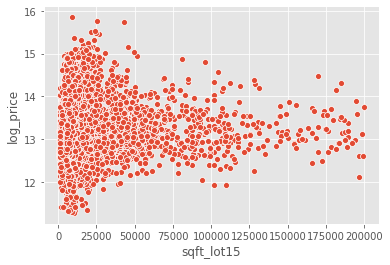

In [117]:
# temp look at sqft_lot less than 200K vs. log_price
temp = preprocessed.loc[preprocessed['sqft_lot15'] <= 200000]
sns.scatterplot(x='sqft_lot15', y='log_price', data=temp)

In [118]:
# not linear, drop this column as it does not meet linearity requirements, even when ignoring outliers / higher values
preprocessed = preprocessed.drop(['sqft_lot15'], axis=1)

In [119]:
#SQFT_LOT

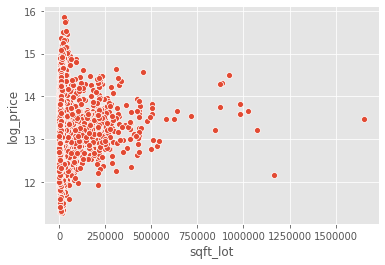

In [120]:
sns.scatterplot('sqft_lot', 'log_price', data=preprocessed)

In [121]:
# how many are greater than 250K
preprocessed.loc[preprocessed['sqft_lot'] > 250000]['log_price'].count()

106

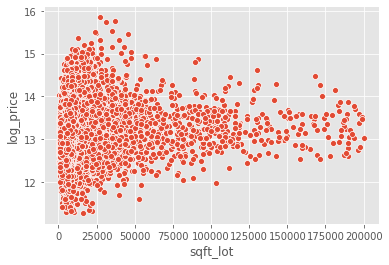

In [122]:
# look at relationship on houses less than 250K
temp = preprocessed.loc[preprocessed['sqft_lot'] <= 200000]
sns.scatterplot(x='sqft_lot', y='log_price', data=temp)

In [123]:
# drop column as it does not meet linearity requirements

In [124]:
preprocessed = preprocessed.drop('sqft_lot', axis=1)

In [125]:
# replot cont variables against price

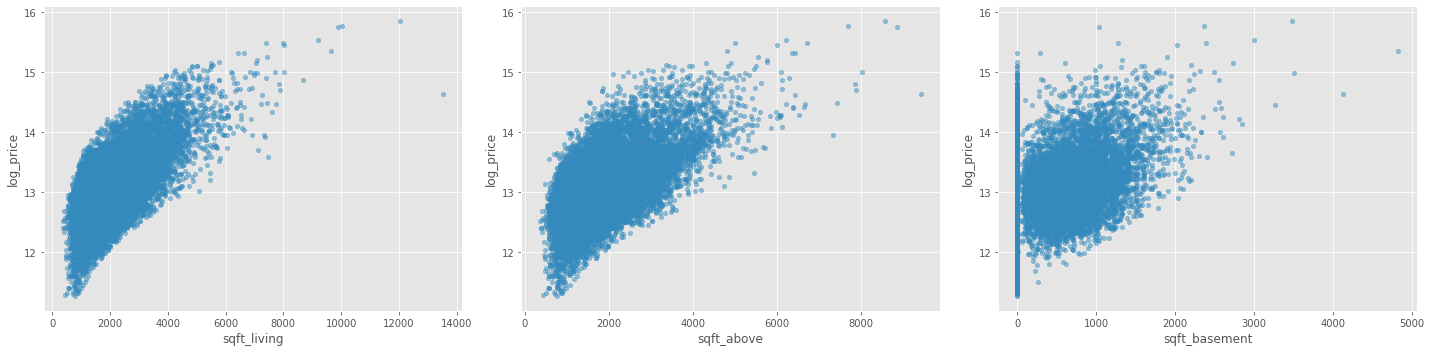

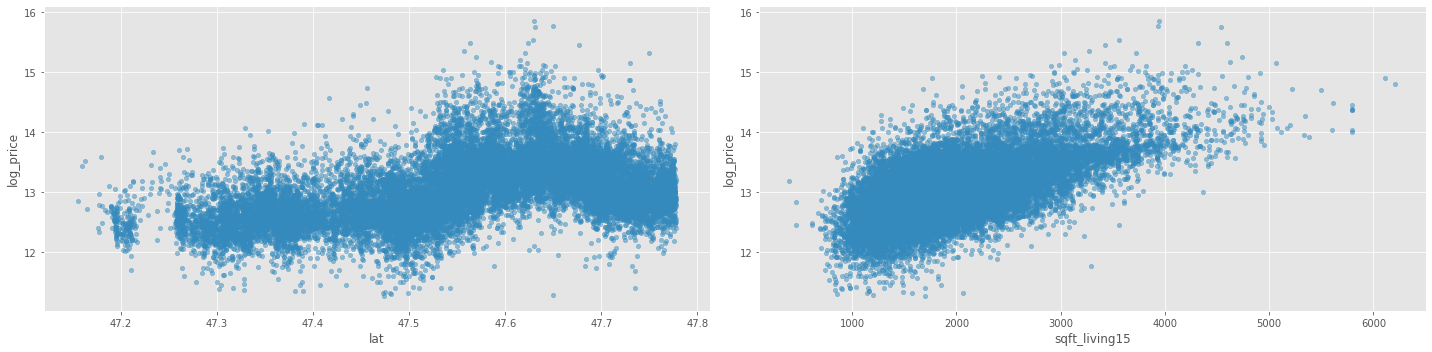

In [126]:
plot_x_y(['sqft_living', 'sqft_above', 'sqft_basement'], 'log_price', data=preprocessed)
plot_x_y(['lat', 'sqft_living15'], 'log_price', data=preprocessed)

In [127]:
# relationships appear relatively linear, will keep these variables in - - lat is not so linear, but may be polynomial
# will evaluate later on

In [128]:
# rerun model with non-linear variables removed - - may impact r2 given reduction in columns
y = preprocessed['log_price']
X = preprocessed.drop('log_price', axis=1)

predictors = sm.add_constant(X)
model = sm.OLS(y, predictors).fit()
model.summary()

/Users/kaigraham/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     510.8
Date:                Wed, 17 Feb 2021   Prob (F-statistic):               0.00
Time:                        21:08:50   Log-Likelihood:                 6363.5
No. Observations:               21597   AIC:                        -1.210e+04
Df Residuals:                   21282   BIC:                            -9583.
Df Model:                         314                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -15.3065      3.410     -4.489      0.000     -21.990      -8.622
bedrooms           0.0023      0.002      1.251      0.211      -0.001       0.006
bathrooms          0.0361      0.003     11.788      0.000       0.030       0.042
sqft_living        0.0001   1.65e-05      7.085      0.000    8.44e-05       0.000
view               0.0638      0.002     32.047      0.000       0.060       0.068
grade              0.0950      0.002     44.973      0.000       0.091       0.099
sqft_above      8.311e-05   1.65e-05      5.031      0.000    5.07e-05       0.000
sqft_basement   1.685e-05   1.63e-05      1.034      0.301   -1.51e-05    4.88e-05
lat                0.5534      0.072      7.677      0.000       0.412       0.695
sqft_living15   7.957e-05   3.32e-06     23.999      0.000    7.31e-05    8.61e-05
floors_1.5         0.0041      0.005      0.769      0.442      -0.006       0.015
floors_2.0        -0.0387      0.005     -8.500      0.000      -0.048      -0.030
floors_2.5        -0.0480      0.015     -3.117      0.002      -0.078      -0.018
floors_3.0        -0.1328      0.010    -13.827      0.000      -0.152      -0.114
floors_3.5        -0.1401      0.069     -2.024      0.043      -0.276      -0.004
waterfront_1.0     0.4544      0.017     27.025      0.000       0.421       0.487
condition_2        0.1462      0.037      3.958      0.000       0.074       0.219
condition_3        0.2678      0.034      7.808      0.000       0.201       0.335
condition_4        0.3249      0.034      9.467      0.000       0.258       0.392
condition_5        0.3907      0.035     11.316      0.000       0.323       0.458
yr_reno_1934.0     0.1118      0.183      0.610      0.542      -0.247       0.471
yr_reno_1940.0    -0.1748      0.130     -1.350      0.177      -0.429       0.079
yr_reno_1944.0     0.1231      0.183      0.672      0.501      -0.236       0.482
yr_reno_1945.0     0.0018      0.106      0.017      0.987      -0.206       0.210
yr_reno_1946.0     0.1662      0.183      0.910      0.363      -0.192       0.524
yr_reno_1948.0    -0.0120      0.183     -0.065      0.948      -0.372       0.348
yr_reno_1950.0    -0.3881      0.184     -2.113      0.035      -0.748      -0.028
yr_reno_1951.0    -0.0436      0.183     -0.238      0.812      -0.403       0.315
yr_reno_1953.0    -0.2424      0.184     -1.314      0.189      -0.604       0.119
yr_reno_1954.0     0.6524      0.183      3.570      0.000       0.294       1.011
yr_reno_1955.0     0.0604      0.106      0.571      0.568      -0.147       0.268
yr_reno_1956.0    -0.1239      0.106     -1.164      0.244      -0.333       0.085
yr_reno_1957.0    -0.0823      0.130     -0.634      0.526      -0.336       0.172
yr_reno_1958.0     0.0531      0.107      0.498      0.619      -0.156       0.262
yr_reno_1959

In [129]:
# cross validation
regression = LinearRegression().fit(predictors, y)
crossvalidation = KFold(n_splits=3, shuffle=True, random_state=1)
model_4 = np.mean(cross_val_score(regression, predictors, y, scoring='r2', cv=crossvalidation))
model_4

0.877659471230717

In [130]:
# check distributions of continous data
meets_lin_requirement = ['sqft_living', 'sqft_above', 'sqft_basement', 'lat', 'sqft_living15']

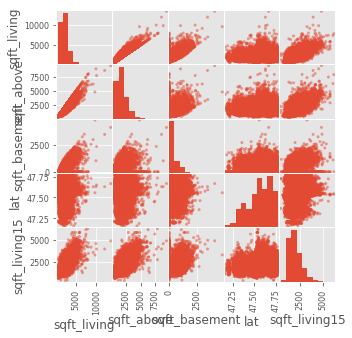

In [131]:
# see which would benefit from log transformations
pd.plotting.scatter_matrix(preprocessed[meets_lin_requirement], figsize=(5, 5))
plt.show()

In [132]:
# log transform sqft_living, sqft_above, sqft_living15
preprocessed['sqft_above_log'] = np.log(preprocessed['sqft_above'])
preprocessed = preprocessed.drop('sqft_above', axis=1)


# where issues start to come in 
# preprocessed['sqft_living15_log'] = np.log(preprocessed['sqft_living15'])
# preprocessed['sqft_living_log'] = np.log(preprocessed['sqft_living'])

# preprocessed.drop(['sqft_living15', 'sqft_living'], axis=1)

In [133]:
# rerun the regression
y = preprocessed['log_price']
X = preprocessed.drop('log_price', axis=1)

predictors = sm.add_constant(X)
model = sm.OLS(y, predictors).fit()
model.summary()

/Users/kaigraham/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     531.1
Date:                Wed, 17 Feb 2021   Prob (F-statistic):               0.00
Time:                        21:08:55   Log-Likelihood:                 6735.4
No. Observations:               21597   AIC:                        -1.284e+04
Df Residuals:                   21282   BIC:                        -1.033e+04
Df Model:                         314                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -16.6346      3.352     -4.962      0.000     -23.205     -10.064
bedrooms          -0.0069      0.002     -3.842      0.000      -0.010      -0.003
bathrooms          0.0319      0.003     10.590      0.000       0.026       0.038
sqft_living     6.615e-05   5.83e-06     11.350      0.000    5.47e-05    7.76e-05
view               0.0621      0.002     31.748      0.000       0.058       0.066
grade              0.0917      0.002     44.100      0.000       0.088       0.096
sqft_basement   7.275e-05   6.38e-06     11.400      0.000    6.02e-05    8.53e-05
lat                0.5385      0.071      7.600      0.000       0.400       0.677
sqft_living15   7.625e-05   3.26e-06     23.391      0.000    6.99e-05    8.26e-05
floors_1.5        -0.0310      0.005     -5.756      0.000      -0.042      -0.020
floors_2.0        -0.0649      0.005    -14.237      0.000      -0.074      -0.056
floors_2.5        -0.0694      0.015     -4.589      0.000      -0.099      -0.040
floors_3.0        -0.1635      0.010    -17.203      0.000      -0.182      -0.145
floors_3.5        -0.1543      0.068     -2.267      0.023      -0.288      -0.021
waterfront_1.0     0.4696      0.017     28.400      0.000       0.437       0.502
condition_2        0.1448      0.036      3.989      0.000       0.074       0.216
condition_3        0.2570      0.034      7.621      0.000       0.191       0.323
condition_4        0.3124      0.034      9.259      0.000       0.246       0.378
condition_5        0.3782      0.034     11.143      0.000       0.312       0.445
yr_reno_1934.0     0.1144      0.180      0.635      0.525      -0.239       0.467
yr_reno_1940.0    -0.1659      0.127     -1.303      0.193      -0.415       0.084
yr_reno_1944.0     0.0486      0.180      0.270      0.787      -0.304       0.402
yr_reno_1945.0     0.0059      0.104      0.057      0.955      -0.199       0.210
yr_reno_1946.0     0.2029      0.179      1.130      0.258      -0.149       0.555
yr_reno_1948.0    -0.0232      0.180     -0.129      0.898      -0.377       0.330
yr_reno_1950.0    -0.3724      0.181     -2.063      0.039      -0.726      -0.019
yr_reno_1951.0    -0.0613      0.180     -0.341      0.733      -0.414       0.292
yr_reno_1953.0    -0.3241      0.181     -1.787      0.074      -0.680       0.031
yr_reno_1954.0     0.6191      0.180      3.447      0.001       0.267       0.971
yr_reno_1955.0     0.0576      0.104      0.554      0.579      -0.146       0.261
yr_reno_1956.0    -0.1489      0.105     -1.423      0.155      -0.354       0.056
yr_reno_1957.0    -0.0955      0.127     -0.750      0.453      -0.345       0.154
yr_reno_1958.0     0.0300      0.105      0.286      0.775      -0.176       0.236
yr_reno_1959.0    -0.2888      0.181     -1.599      0.110      -0.643       0.065
yr_reno_1960

In [134]:
# cross fold validation
regression = LinearRegression().fit(predictors, y)
crossvalidation = KFold(n_splits=3, shuffle=True, random_state=1)

In [135]:
model_5 = cross_val_score(regression, predictors, y, scoring='r2', cv=crossvalidation)

In [136]:
model_5

array([0.88439901, 0.88293513, 0.8784189 ])

In [137]:
model_5_av = np.mean(model_5)

In [138]:
model_5_av

0.8819176803261954

In [139]:
# remove multi-collinearity
# check for multicollinearity and remove where necessary
data_pred = preprocessed.iloc[:, 2:]
data_pred.head()

,sqft_living,view,grade,sqft_basement,lat,sqft_living15,log_price,floors_1.5,floors_2.0,floors_2.5,...,day_sold_23,day_sold_24,day_sold_25,day_sold_26,day_sold_27,day_sold_28,day_sold_29,day_sold_30,day_sold_31,sqft_above_log
0,1180,0.0,7,0.0,47.5112,1340,12.309982,0,0,0,...,0,0,0,0,0,0,0,0,0,7.073270
1,2570,0.0,7,400.0,47.7210,1690,13.195614,0,1,0,...,0,0,0,0,0,0,0,0,0,7.682482
2,770,0.0,6,0.0,47.7379,2720,12.100712,0,0,0,...,0,0,1,0,0,0,0,0,0,6.646391
3,1960,0.0,7,910.0,47.5208,1360,13.311329,0,0,0,...,0,0,0,0,0,0,0,0,0,6.956545
4,1680,0.0,8,0.0,47.6168,1800,13.142166,0,0,0,...,0,0,0,0,0,0,0,0,0,7.426549


In [140]:
# return only highly correlated pairs
# save absolute value of correlation matrix as data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df = data_pred.corr().abs().stack().reset_index().sort_values(0, ascending=False)

#zip the variable name columns (named level_0 and level_1 by default) in a new column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))

#set index to pairs
df.set_index(['pairs'], inplace=True)

#drop level columns
df.drop(columns=['level_1', 'level_0'], inplace=True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

# drop duplicates
df.drop_duplicates(inplace=True)

In [141]:
# get pairs that are more than 75% correlated
df[(df.cc>.75) & (df.cc<1)]

,cc
pairs,
"(sqft_above_log, sqft_living)",0.843133
"(condition_3, condition_4)",0.812294
"(sqft_living, grade)",0.762779
"(sqft_living, sqft_living15)",0.756402
